In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt

# Directories for images and masks
images_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_dataset"
masks_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_masks"

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 20

# Data Loading and Preprocessing
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0
    return img

def preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask, tf.float32)
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)  # Convert to one-hot
    return mask

def load_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img, mask: (preprocess_image(img), preprocess_mask(mask)))
    return dataset

# Load dataset
dataset = load_data(images_dir, masks_dir)

# Split into training and validation datasets
total_images = len(list(os.listdir(images_dir)))
train_size = int(0.8 * total_images)  # 80% for training
val_size = total_images - train_size  # Remaining 20% for validation

train_dataset = dataset.take(train_size).batch(BATCH_SIZE).shuffle(100)
val_dataset = dataset.skip(train_size).batch(BATCH_SIZE)

# Define U-Net model
def build_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)
    return models.Model(inputs, outputs)

# Initialize model
model = build_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# Class weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust as needed

# Training with class weights
def weighted_loss(y_true, y_pred):
    # Convert class_weights dict to a tensor
    class_weights_tensor = tf.constant([class_weights[0], class_weights[1]], dtype=tf.float32)

    # Compute the sample weights by selecting the corresponding class weight
    sample_weights = tf.reduce_sum(y_true * class_weights_tensor, axis=-1)

    # Compute the unweighted loss
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Return the weighted loss
    return unweighted_loss * sample_weights

model.compile(optimizer=Adam(learning_rate=1e-4), loss=weighted_loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS)

# Save the model
model.save("unet_teeth_segmentation.h5")

# Evaluation
def evaluate_model(model, dataset):
    iou_metric = MeanIoU(num_classes=NUM_CLASSES)
    pixel_accuracy = tf.keras.metrics.BinaryAccuracy()
    all_ious = []

    for images, masks in dataset:
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)
        true_masks = tf.argmax(masks, axis=-1)

        for i in range(predictions.shape[0]):
            pred = predictions[i].numpy().flatten()
            true = true_masks[i].numpy().flatten()

            # Compute IoU and accuracy
            iou_metric.update_state(true, pred)
            pixel_accuracy.update_state(true, pred)
            all_ious.append(iou_metric.result().numpy())

    print("Mean IoU:", np.mean(all_ious))
    print("Pixel Accuracy:", pixel_accuracy.result().numpy())

# Call evaluation
evaluate_model(model, val_dataset)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 146s 17s/step - accuracy: 0.7402 - loss: 0.7423 - val_accuracy: 0.9913 - val_loss: 0.6802
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 130s 16s/step - accuracy: 0.9894 - loss: 0.6530 - val_accuracy: 0.9913 - val_loss: 0.4122
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 128s 18s/step - accuracy: 0.9910 - loss: 0.4674 - val_accuracy: 0.9913 - val_loss: 0.4335
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 126s 16s/step - accuracy: 0.9906 - loss: 0.4368 - val_accuracy: 0.9913 - val_loss: 0.3988
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 127s 16s/step - accuracy: 0.9903 - loss: 0.4178 - val_accuracy: 0.9913 - val_loss: 0.3799
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 128s 16s/step - accuracy: 0.9901 - loss: 0.4007 - val_accuracy: 0.9913 - val_loss: 0.3417
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 126s 16s/step - accuracy: 0.9894 - loss: 0.3749 - val_accuracy: 0.9913 - val_loss: 0.2926
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 128s 16s/step - accuracy: 0.9904 - loss: 0.3018 - val_accuracy: 0.9913 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Mean IoU: 0.5365687
Pixel Accuracy: 0.98276687


In [2]:
# Evaluation with IoU for each class
def evaluate_model_with_class_iou(model, dataset):
    # Initialize IoU and accuracy metrics
    iou_metric = MeanIoU(num_classes=NUM_CLASSES)
    pixel_accuracy = tf.keras.metrics.BinaryAccuracy()
    
    # To store IoU for each class
    class_ious = np.zeros(NUM_CLASSES)

    for images, masks in dataset:
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)
        true_masks = tf.argmax(masks, axis=-1)

        # Iterate over each sample in the batch
        for i in range(predictions.shape[0]):
            pred = predictions[i].numpy().flatten()
            true = true_masks[i].numpy().flatten()

            # Update the IoU metric for all classes
            iou_metric.update_state(true, pred)
            pixel_accuracy.update_state(true, pred)

            # Calculate IoU for each class (for this image)
            for class_idx in range(NUM_CLASSES):
                intersection = np.sum((pred == class_idx) & (true == class_idx))
                union = np.sum((pred == class_idx) | (true == class_idx))
                class_ious[class_idx] += intersection / (union + 1e-10)  # To prevent division by zero

    # Compute average IoU for each class
    class_ious /= len(dataset)

    print("Class-wise IoU:")
    for i in range(NUM_CLASSES):
        print(f"Class {i}: IoU = {class_ious[i]:.4f}")

    print("Mean IoU:", np.mean(class_ious))
    print("Pixel Accuracy:", pixel_accuracy.result().numpy())

# Call evaluation
evaluate_model_with_class_iou(model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class-wise IoU:
Class 0: IoU = 14.2497
Class 1: IoU = 1.1050
Mean IoU: 7.677360617265177
Pixel Accuracy: 0.98276687


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


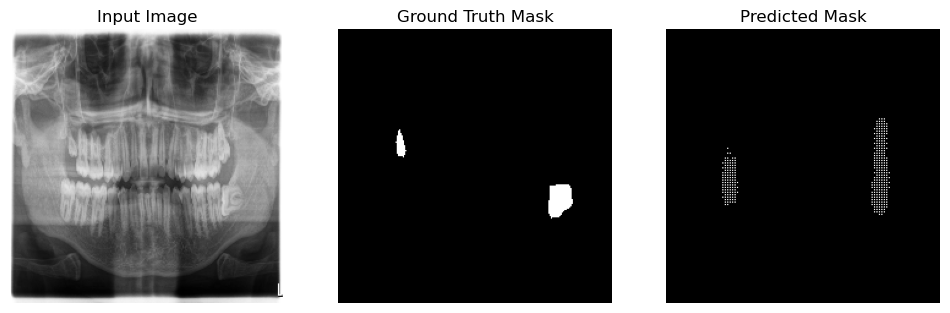

In [3]:
# Directories for images and masks
images_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_dataset"
masks_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_masks"

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 2

# Function to load and preprocess the input image
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)  # Ensure the image is grayscale
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    return img

# Function to load and preprocess the mask (ground truth)
def load_and_preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask, tf.float32)
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)  # Convert to one-hot encoding
    return mask

# Load and preprocess the ground truth mask and input image
def load_data_for_prediction(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)
    return image[tf.newaxis, ...], mask[tf.newaxis, ...]

# Function to display the original image, ground truth mask, and predicted mask
def display_results(image, ground_truth_mask, predicted_mask):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(tf.argmax(ground_truth_mask, axis=-1)[0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(tf.argmax(predicted_mask, axis=-1)[0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Load the model (assuming the model is already saved)
model = tf.keras.models.load_model("unet_teeth_segmentation.h5", custom_objects={"weighted_loss": weighted_loss})

# Get a random image from the dataset
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# You can choose any image-mask pair; for now, we use the first image in the directory
image_path = os.path.join(images_dir, image_files[0])  # Change the index as needed
mask_path = os.path.join(masks_dir, mask_files[0])    # Change the index as needed

# Load the data for prediction
image, ground_truth_mask = load_data_for_prediction(image_path, mask_path)

# Get the predicted mask from the model
predicted_mask = model.predict(image)

# Display the results
display_results(image, ground_truth_mask, predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


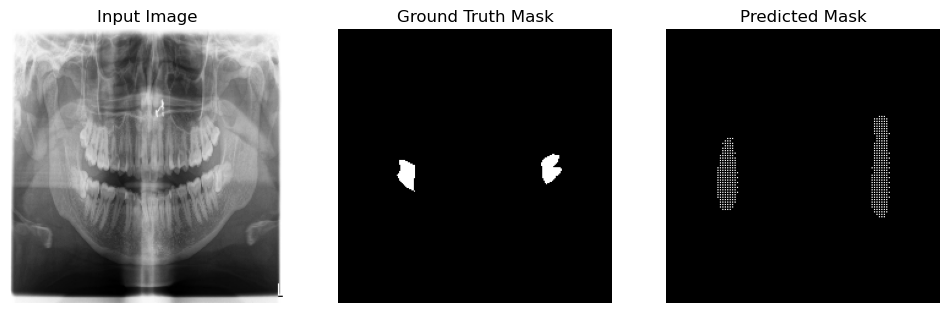

In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Directories for images and masks
images_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_dataset"
masks_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_masks"

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 2

# Function to load and preprocess the input image
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)  # Ensure the image is grayscale
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    return img

# Function to load and preprocess the mask (ground truth)
def load_and_preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask, tf.float32)
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)  # Convert to one-hot encoding
    return mask

# Load and preprocess the ground truth mask and input image
def load_data_for_prediction(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)
    return image[tf.newaxis, ...], mask[tf.newaxis, ...]

# Function to display the original image, ground truth mask, and predicted mask
def display_results(image, ground_truth_mask, predicted_mask):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(tf.argmax(ground_truth_mask, axis=-1)[0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(tf.argmax(predicted_mask, axis=-1)[0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Load the model (assuming the model is already saved)
model = tf.keras.models.load_model("unet_teeth_segmentation.h5", custom_objects={"weighted_loss": weighted_loss})

# Get the list of image and mask files
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# Function to test with a specific image
def test_with_image(index):
    if index < 0 or index >= len(image_files):
        print("Invalid index. Please choose an index between 0 and", len(image_files) - 1)
        return

    # Get the image and mask paths based on the selected index
    image_path = os.path.join(images_dir, image_files[index])
    mask_path = os.path.join(masks_dir, mask_files[index])

    # Load the data for prediction
    image, ground_truth_mask = load_data_for_prediction(image_path, mask_path)

    # Get the predicted mask from the model
    predicted_mask = model.predict(image)

    # Display the results
    display_results(image, ground_truth_mask, predicted_mask)

# Example: Test with the 3rd image (index 2)
test_with_image(100)  # Change the index as needed (0-based index)